В данном блокноте мы научимся работать с библиотекой глубокого обучения Keras. Будем использовать алгоритм , приведенный в https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html, с некоторыми добавлениями и исправлениями.
Наша цель — быстро и просто создать классификатор изображений, используя относительно небольшое (1000) количество обучающих примеров для каждого класса.

Для начала загрузим необходимые библиотеки и создадим необходимые директории.

In [ ]:
!pip istall -q tensorflow==2.8.0
!pip istall -q keras==2.8.0

In [1]:
from keras.preprocessing.image import  array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw 
import os, random, shutil
from PIL import ImageFile
import zipfile 
ImageFile.LOAD_TRUNCATED_IMAGES = True


if not os.path.exists('test/train/cats/'):
  os.makedirs('test/train/cats/')
if not os.path.exists('test/train/dogs/'):
  os.makedirs('test/train/dogs/')  
if not os.path.exists('test/preview/'):
  os.makedirs('test/preview/')   
if not os.path.exists('test/validation/сats'):
  os.makedirs('test/validation/cats') 
if not os.path.exists('test/validation/dogs'):
  os.makedirs('test/validation/dogs')   

FileExistsError: [Errno 17] File exists: 'test/validation/cats'

Наша задача — обучить модель на сравнительно небольшом количестве исходных данных. Конечно, это количество имеет смысл увеличить с помощью аугментации, т.е. трансформации исходного изображения (изменения масштаба, сдвига, горизонтального отражения).

Давайте для начала рассмотрим аугментацию на примере одного изображения, произвольно выбранного, например, из папки validation/dogs/.

Воспользуемся ImageDataGenerator и командой .flow(). Полученные трансформированные изображения поместим в папку preview/. Во избежании зацикливания генерации, установим лимит, равный 4.


Поскольку у нас сравнительно небольшое количество изображений, мы можем столкнуться с проблемой переобучения, то есть проблемой, когда модель изучает шаблоны, которые не обобщаются на новые данные, то есть когда модель начинает использовать нерелевантные функции для прогнозирования. Например, если у кошки есть бантик, это не означает, что все животные с бантиком - кошки. Чтобы избежать переобучения, необходимо сосредоточиться на наиболее важных функциях, обнаруженных в данных, и они с большей вероятностью будут действительно актуальными и лучше обобщать. Один из способов (именно его будем использовать) это выбор количества слоев и размера каждого слоя.

В нашем случае мы будем использовать очень маленькую свертку с несколькими слоями и несколькими фильтрами на слой, наряду с увеличением и отключением данных. Отключение также помогает уменьшить переообучение, не позволяя слою видеть дважды один и тот же шаблон, тем самым действуя аналогично увеличению данных (и выпадение, и увеличение данных имеют тенденцию нарушать случайные корреляции).

Начнем строить нашу модель. Выберем модель Sequential представляет собой линейный стек слоев. В нашем случае будет три сверточных слоя с активацией ReLU (Rectified Linear Unit) и последующими слоями максимального объединения.

In [3]:
import tensorflow as ts
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

img_width, img_height = 150, 150 # ширина, высота изображений

train_data_dir = 'sample_data/test/train' # директория с изображениями кошек и собак для последующего обучения модели
validation_data_dir = 'sample_data/test/validation' # директория с изображениями для тестирования модели
nb_train_samples = 2000 # количество тренировочных изображений
nb_validation_samples = 800 # количество изображений для тестирования
epochs = 30 # количество эпох (итераций)
batch_size = 16 # данные разбиваются на "пакеты" размером "batch_size"

if K.image_data_format() == 'channels_first': # для сохранения упорядочевания весов при переключении модели с одного формата данных на другой
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = ts.keras.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape)) # добавляем сверточный 2D-слой. Поскольку это 1-ый слой, необходимо задать ключевой аргумент input_shape
# 32 - количество выходных фильтров в свертке, т.е. сколько признаков будем искать
# (3, 3) - kernel_size-высота и ширина окна 2D свертки
# Имеется 32 фильтра, каждый 3x3x3 (т. е. 27 весов), плюс 1 для смещения (т. е. всего 28 весов каждый). 32 фильтра * 28 весов = 896 параметров.
model.add(Activation('relu')) # указываем функцию активации. В данном случае f(z)=max(0,z)
model.add(MaxPooling2D(pool_size=(2, 2))) # уменьшим размер исходной матрицы (этот слой обязателен после сверточных слоев)

model.add(Conv2D(32, (3, 3))) # добавляем второй сверточный слой
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3))) # добавляем третий сверточный слой (размер фильтра увеличивается, так что сеть уже может изучать более сложные представления)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # слой, преобразующий 2D-данные в 1D-данные
model.add(Dense(64)) # добавляем полносвязный слой с указанием числа выходов
model.add(Activation('relu'))
model.add(Dropout(0.5)) # добавляем слой, обнуляющий в модели часть весов, чтоб избежать переобучения (0,5 означает, что он отбрасывает 50% существующих соединений)
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-30 20:56:40.881416: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-05-30 20:56:40.881449: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-05-30 20:56:40.881458: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-05-30 20:56:40.881485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-30 20:56:40.881504: I tensorflow/core/common_runtime/pluggable_device/plugg


Посмотреть информацию о скомпилированной модели можно  следующим образом:


In [4]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 72, 72, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212,513 (4.63 MB)

 Trainable params: 1,212,513 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
model.load_weights("Model_10k_images_cats_dogs_trained/Model_10k_images.h5")

Создадим отдельные генераторы для тренировочных и тестовых изображений:

In [12]:
if not os.path.exists('test/train/cats/'):
  os.makedirs('test/train/cats/')
if not os.path.exists('test/train/dogs/'):
  os.makedirs('test/train/dogs/')

In [13]:
zip_file = "train.zip"
startswith_cats = "cat" # начало имени файла для кошек
startswith_dogs = "dog" # начало имени файла для собак
with zipfile.ZipFile(zip_file, 'r') as z:
  for file in z.namelist():
    file_new = file.rsplit( "/", 1 )[ 1 ]
    if not (file_new.startswith(startswith_cats) or file_new.startswith(startswith_dogs)): continue
    i = int(file_new.split('.')[1])
    if file_new.startswith(startswith_cats) and i >= 10500 and i < 10600:
      z.extract(file, 'test/')
      os.replace('test/train/'+file_new,'test/train/cats/'+file_new)
    elif file_new.startswith(startswith_dogs) and i >= 10500 and i < 10600:
      z.extract(file,'test/')
      os.replace('test/train/'+file_new,'test/train/dogs/'+file_new)


In [14]:
!mkdir test
!mkdir test/cat
!mkdir test/dog
!cp test/train/cats/cat.10533.jpg test/cat/cat.jpg
!cp test/train/dogs/dog.10533.jpg test/dog/dog.jpg
     

mkdir: test: File exists
mkdir: test/cat: File exists
mkdir: test/dog: File exists


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 150, 150
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "test",
    target_size=(img_width, img_height),
    batch_size=2,
    class_mode='binary',
    shuffle=False)

imgs, labels = next(test_generator)
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=np.round(model.predict(imgs)).flatten()

print(predictions)
print(labels)
# если label=0 - это кот и ответ = 1 - pred

img_width, img_height = 150, 150
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "test/train",
    target_size=(img_width, img_height),
    batch_size=200,
    class_mode='binary',
    shuffle=False)

Found 1006 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[0. 0.]
[0. 1.]
Found 200 images belonging to 2 classes.


In [18]:
imgs, labels = next(test_generator)
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=np.round(model.predict(imgs)).flatten()
print(predictions)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0.]


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("f1")
print(f1_score(labels, predictions, average='macro'))

print("precision")
print(precision_score(labels, predictions, average='macro'))

print("recall")
print(recall_score(labels, predictions, average='macro'))
     

f1
0.8492613807657522
precision
0.8569971440228478
recall
0.8500000000000001


In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "test/cat/",
    target_size=(img_width, img_height),
    batch_size=4,
    class_mode='binary',
    shuffle=False)

imgs, labels = next(test_generator)
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=(model.predict(imgs)).flatten()
print(predictions)
print(1 - 0.2377117)

Found 2 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[0.2377117  0.37811837]
0.7622883


Found 800 images belonging to 2 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


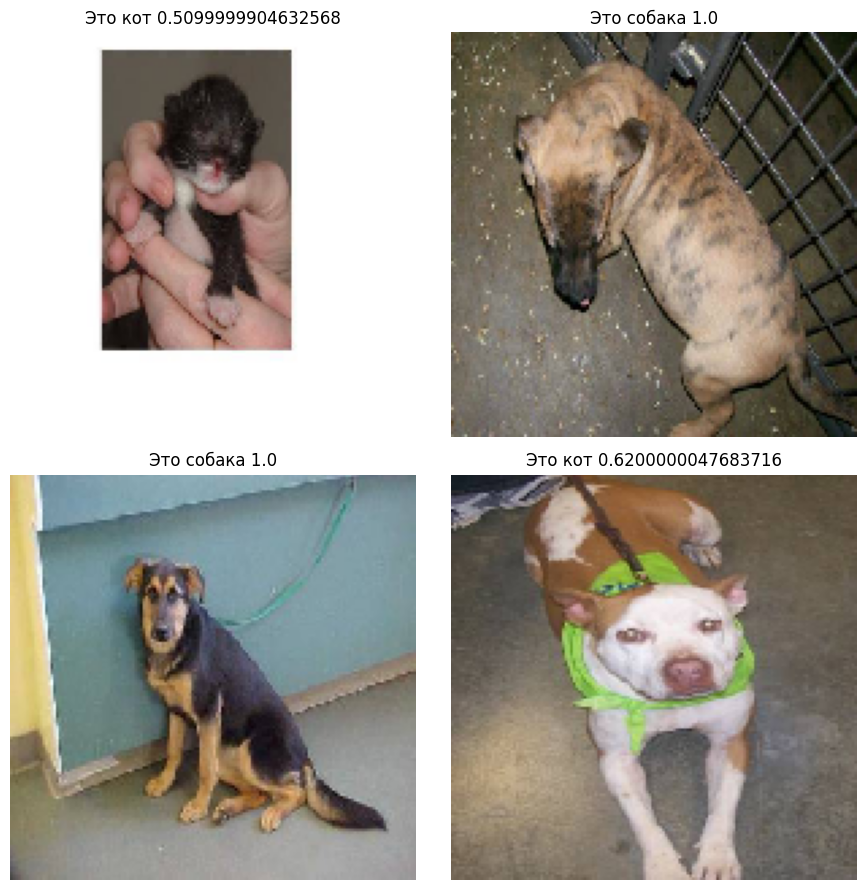

In [47]:
test_dir = 'test/validation/'
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=800, 
    class_mode='binary')
imgs,labels=next(test_generator)
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
rounded_pred=np.asarray([np.round(i) for i in predictions])
list1 = [item for item in zip(array_imgs, rounded_pred, labels, predictions)]
fig = plt.figure(figsize=(9,9))
# выведем результат для 4-х любых изображений
for i in range(1,5):
    item = random.choice(list1)
    img = item[0] 
    ax = fig.add_subplot(2, 2, i)
    plt.axis('off')
    ax.imshow(np.transpose(img,(1,0,2)))
    if np.round(item[3][0], 2) <= 0.5:
      ax.set_title('%s %s' % ('Это кот',1 - np.round(item[3][0], 2)), fontsize=12)
    else:
      ax.set_title('%s %s' % ('Это собака',np.round(item[3][0])), fontsize=12)    
fig.tight_layout()
plt.show()




В блоге https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html приводятся несколько вариантов усовершенствования нашей модели.

Предлагается ознакомится с ними самостоятельно и сравнить результаты.